In [82]:
from matplotlib import pyplot as plt
import platform, os, sys, h5py
import numpy as np
from tabulate import tabulate
from pprint import pprint
from tqdm import tqdm

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append('/Volumes/slab/_Data/170422 - EonHe M018V6 with L3 etch/experiment')
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    %config InlineBackend.figure_format='retina'

from Common import common, kfit
from TrapAnalysis import trap_analysis, import_data, artificial_anneal as anneal
from HeliumSurface.static_surface import *
from ipywidgets import interact
from mpltools import color

%matplotlib inline

In [83]:
def Qeff(delta, gamma, g, omega0):
    return omega0/gamma * (delta/g)**2

def Qtot(Qef, Qi):
    return 1/(1/Qef + 1/Qi)

def omegae2volts(f_array, f_electron_1V=22E9):
    return f_array**2/(f_electron_1V**2)

/Users/gkoolstra/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


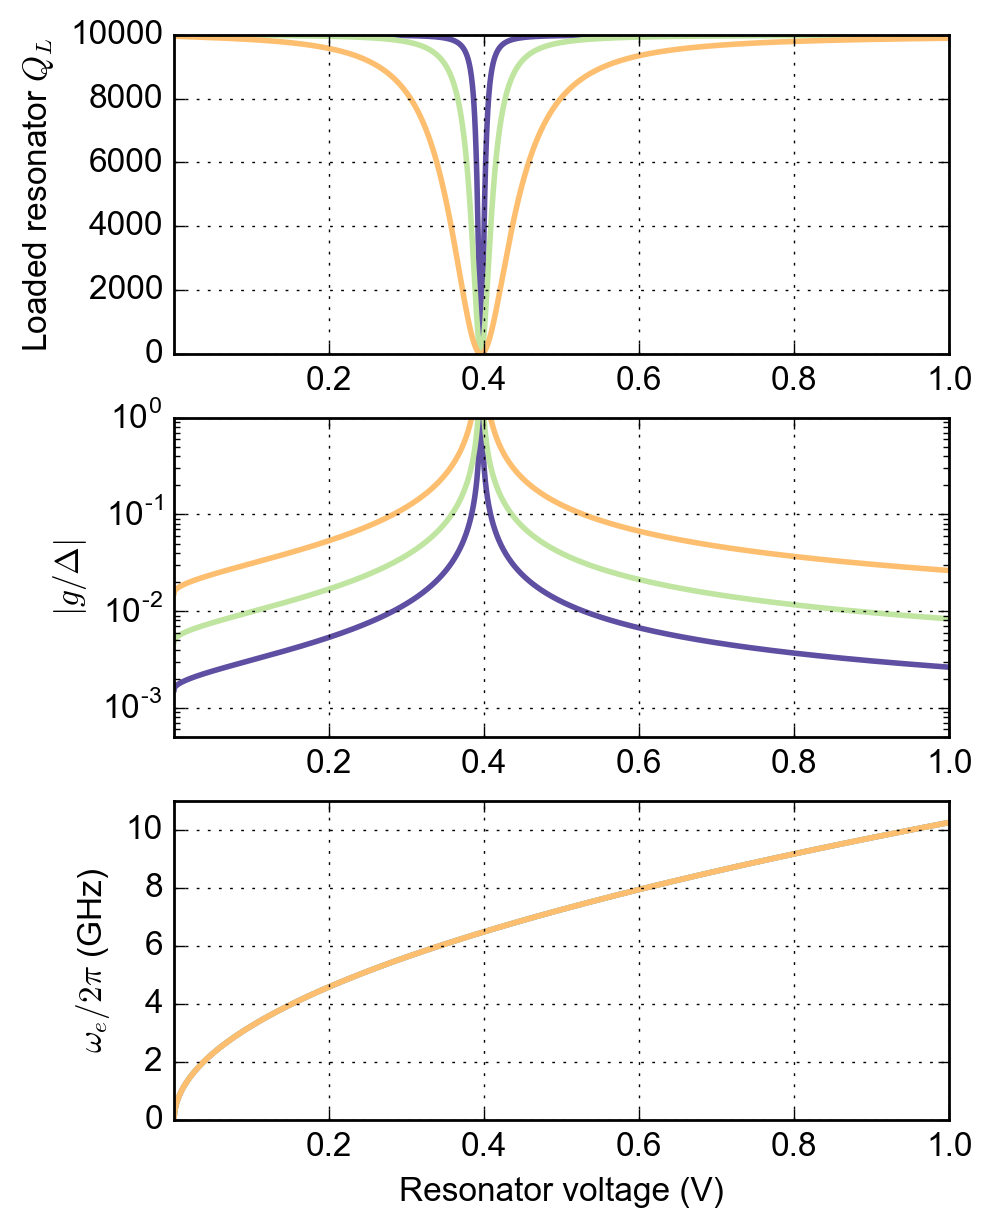

In [117]:
N = [1E4, 1E5, 1E6]

color.cycle_cmap(len(N)+1, cmap=plt.cm.Spectral_r)

plt.figure(figsize=(5.,7.))
common.configure_axes(12)

f0 = 6.45E9
delta = 2*np.pi*np.linspace(-f0, 20e9, 1E4)
omega0 = 2*np.pi*f0
gamma = 2*np.pi*1e7

V_axis = omegae2volts(f0 + delta/(2*np.pi), f_electron_1V=10.25E9)

for n in N:
    g = np.sqrt(n) * 2*np.pi*1E5
    Qs = Qeff(delta, gamma, g, omega0)
    plt.subplot(311)
    plt.plot(V_axis, Qtot(Qs, 1E4), lw=2.0)
    
    plt.subplot(312)
    plt.plot(V_axis, np.abs(g/delta), lw=2.0)
    plt.xlim(np.min(V_axis), 1.0)#np.max(V_axis))
    plt.yscale('log')
    plt.ylabel(r"$|g/\Delta|$")
    plt.grid()
    plt.ylim(-1, 1)
    

    plt.subplot(313)
    plt.plot(V_axis, (f0 + delta/(2*np.pi))/1E9, lw=2.0)
    plt.ylim(0, 11)
    plt.xlim(np.min(V_axis), 1.0)#np.max(V_axis))
    plt.ylabel("$\omega_e/2\pi$ (GHz)")
    plt.xlabel("Resonator voltage (V)")
    plt.grid()
    
plt.subplot(311)
plt.xlim(np.min(V_axis), 1.0)#np.max(V_axis))
plt.ylabel("Loaded resonator $Q_L$")
plt.grid()

In [23]:
def random_f0(mu, sigma):
    return mu + sigma*np.random.randn()

def lor(f, f0, kappa):
    return 1/(1 + (f-f0)**2/kappa**2)

def average_random_lor(f, expected_f0, f0_jitter, kappa, N):
    for n in range(N):
        if n == 0: 
            signal = lor(f, random_f0(expected_f0, f0_jitter), kappa)
        else:
            signal += lor(f, random_f0(expected_f0, f0_jitter), kappa)
    
    return signal/np.float(N)    

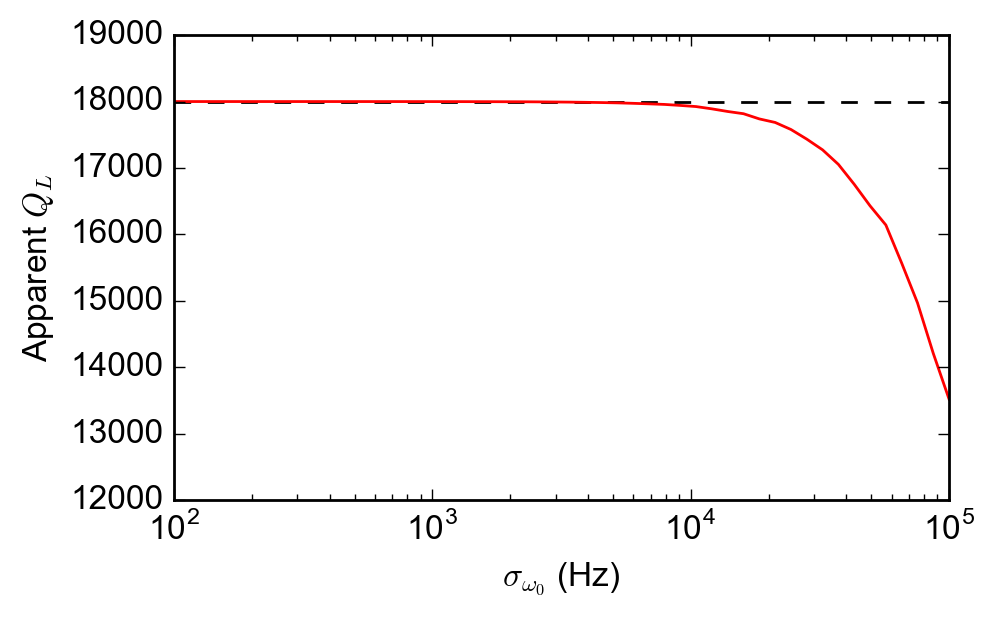

In [55]:
f = np.linspace(6.40E9, 6.41E9, 1E3)
expected_f0 = 6.405E9
kappa = 0.5*expected_f0/18000.
N = 1000
jitters = np.logspace(2, 5)

Qs = list()
for f0_jitter in jitters:
    y = average_random_lor(f, expected_f0, f0_jitter, kappa, N)

#     plt.figure(figsize=(5.,3.))
#     plt.plot(f, y, '-k')
#     plt.yscale('log')

    fr, ferr = kfit.fit_lor(f, y, domain=(expected_f0-1E6, expected_f0+1E6), verbose=False)
#     plt.plot(f, kfit.lorfunc(f, *fr), '-r')

    Qs.append(fr[2]/(2*fr[3]))

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(jitters, Qs, '-r')
plt.xscale('log')
plt.hlines(expected_f0/(2*kappa), 1E2, 1E5, linestyles='--') 
plt.ylim(12E3, 19E3)
plt.xlabel(r"$\sigma_{\omega_0}$ (Hz)")
plt.ylabel("Apparent $Q_L$")